# Beam Loading in TW structures

In [1]:
%plot -f SVG

In [2]:
RF_Track;


RF-Track, version 2.3.3a0

Copyright (C) 2016-2025 CERN, Geneva, Switzerland. All rights reserved.

Author and contact:
 Andrea Latina <andrea.latina@cern.ch>
 BE-ABP Group
 CERN
 CH-1211 GENEVA 23
 SWITZERLAND

This software is distributed under a CERN proprietary software
license in the hope that it will be useful, but WITHOUT ANY WARRANTY;
not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

See the COPYRIGHT and LICENSE files at the top-level directory of
the RF-Track download area: https://gitlab.cern.ch/rf-track

RF-Track was compiled with GSL-2.7 and fftw-3.3.10



Available in Lattice and Volume </br>
Based on a power diffusive model: 
$$
- \frac{\partial G}{\partial t} = v_g \frac{\partial G}{\partial z} + \left( \frac{\partial v_g}{\partial z} - \frac{v_g}{r/Q}\frac{\partial (r/Q)}{\partial z} + \frac{\omega}{Q} \right)\frac{G}{2} + \frac{\omega \frac{r}{Q}\mathcal{T} I}{2}
$$
where:
- G is the accelerating gradient, defined as $ G = \frac{1}{L} \int_0^L |\tilde{E}_z(z)|\text{d}z$
- $Q$ - Unloaded quality factor.
- $r/Q$ - Normalized shunt impedance per unit length (geometrical)
- $v_g$ Group velocity
- $\mathcal{T}$ is the time-transit factor (for on-crest particles in TW structures, $\mathcal{T} = 1$)
- $\tilde{I} = \frac{q_\text{bunch}F(\omega)}{T_\text{RF}}$, with $T_\text{RF} = \frac{1}{f}$ and $F(\omega)$ the bunch form factor

Further information can be found at: 
- Olivares Herrador J, Latina A, Aksoy A, Fuster Martínez N, Gimeno B and Esperante D(2024). *Implementation of the beam-loading effect in the tracking code RF-track based on a power-diffusive model.* Front. Phys. 12:1348042. doi: 10.3389/fphy.2024.1348042

Required arguments:
- [Option a]: Fieldmap + unloaded Q_factor $Q$ + Group velocity $v_g$
- [Option b]: Normalized shunt impedance per unit length $r/Q$ + unloaded Q_factor $Q$ + Group velocity $v_g$ (Preferred)

## Example: CLIC main accelerating TW structure
### Define TW structure

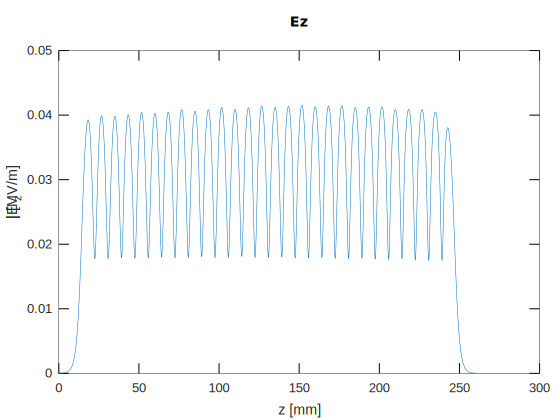

In [3]:
% Import fieldmap from file
load data/efield.dat.gz;

Ez = squeeze(Ez(1,1,:)); % V/m - On axis field
N = length(Ez);
L = (N - 1) * hz; % m - Total Length
z_field = linspace(0, L * 1000, N); % mm
freq = 11.994 * 1e9; % Hz

%% Figure 1: Understand fieldmap
plot(z_field, abs(Ez)/1e6)
xlabel('z [mm]'); ylabel(' |E_z| [MV/m]')
title('Ez')

We define the RF_Fieldmap (TWS):

In [4]:
% RF-element
TWS = RF_FieldMap_1d (Ez, hz, L, freq, 1);
TWS.set_odeint_algorithm('rk2');

The given fieldmap has an amplitude of 0.04 MV/m, corresponding to an input power of $P_\text{map}$ = 4W. If we want to scale it to a given power $P_\text{actual}$, we need to set it as follows:

In [5]:
Pmap    = 4; % W - input field map
Pactual = 61.3e6; % W
TWS.set_P_map( Pmap ); 
TWS.set_P_actual( Pactual ); 

Now the fieldmap is rescaled according to the factor $\sqrt{\frac{P_\text{actual}}{P_\text{map}}}$. 

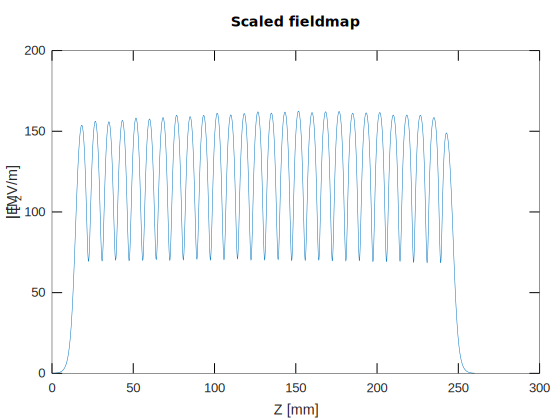

In [6]:
abs_Ez = []; 

TWS.set_t0(0.0)
for z = z_field
    % read the field along the axis
    [E,B] = TWS.get_field_complex(0, 0, z, 0);
    abs_Ez = [ abs_Ez abs(E(3)) ];
end
TWS.unset_t0();

plot(z_field, abs_Ez / 1e6);
xlabel('Z [mm]');
ylabel('|E_z| [MV/m]');
title('Scaled fieldmap')

### Define BL constructor

#### a) Steady BL effect

In [7]:
% Beam-Loading required arguments
VG  = [1.65, 1.2, 0.83]/100; % c 
QQ  = [5536, 5635, 5738]; % Quality factor
R_Q = [14587 16220 17954]; % Ohm/m 
phaseadvance = 2*pi/3; % rad
Ncells = 27; % number of cells

% Bunch specification 
charge = 600; % pC
population = charge * RF_Track.pC; % e
Nbunches = 312; 
fb = freq / 6; % Hz - Frequency of repetition of the bunches

%% A) STEADY-STATE CONSTRUCTOR
BL_steady = BeamLoading (Ncells, freq, phaseadvance, QQ, R_Q, VG, -1, population, fb);


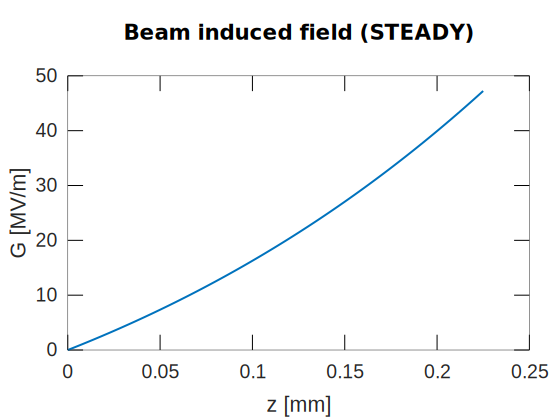

In [8]:
% Some information
G_steady = BL_steady.get_G_steady() / 1e6; % MV/m 
N = length(G_steady); 
z0 = BL_steady.get_z0; 
z1 = BL_steady.get_z1;
zplot = linspace(z0,z1,N); 

f2 = figure(2); 
plot(zplot, G_steady,'LineWidth',2)
xlabel('z [mm]', 'FontSize', 15)
ylabel(' G [MV/m]', 'FontSize', 15)
title('Beam induced field (STEADY)' , 'FontSize', 15)
set(gca,'FontSize',15)

#### b) Transient BL effect (uncompensated)

In [9]:
% B) TRANSIENT STATE CONSTRUCTOR 
tic
BL = BeamLoading(Ncells, freq, phaseadvance, QQ, R_Q, VG);
toc 

Elapsed time is 4.47188 seconds.


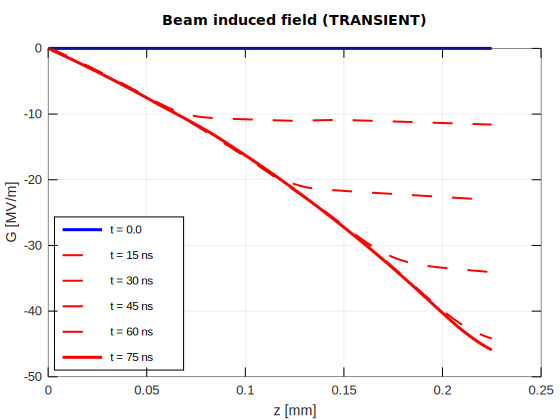

In [10]:
% Information - Calculate transient gradient for trains with equal bunches
BL.solve_pde_transient(-1 * population, fb, Nbunches); 

G           = -BL.get_G() / 1e6; % MV/m
[N,M]       = size(G);
Lcell       = BL.get_Lcell * 1000; % mm
dt          = BL.get_dt; % mm/c -- by default, dt is always Lcell/10
last_t      = (M-1)*dt; % mm/c
t_transient = linspace(0, last_t, M); % mm/c 

tplot  = [0:15:75] * RF_Track.ns; % mm/c
indexx = ceil(tplot /dt) +1; 

plot(zplot,G(:,1),'b','LineWidth',3) % unloaded
for s = indexx(2:end-1)
    hold on
    plot(zplot, G(:,s),'--r','LineWidth',2) 
endfor
plot(zplot, G(:,end), 'r', 'LineWidth',3)
grid on

xlabel('z [mm]'); ylabel(' G [MV/m]'); 
title('Beam induced field (TRANSIENT)')
h = legend('t = 0.0', 't = 15 ns', 't = 30 ns', 't = 45 ns', 't = 60 ns',  't = 75 ns', 'Location', 'SouthWest' );


### Define a bunch

In [11]:
% Define bunch
Part.mass = RF_Track.electronmass; % MeV/c2
Part.Q = -1; % e
Part.P = 90; % MeV
Psigma = 20; % permille

Twiss = Bunch6d_twiss();
Twiss.emitt_x = 600/1e6; % mm.mrad normalised emittance
Twiss.emitt_y = 10/1e6;  % mm.mrad
Twiss.beta_x = 10;       % m
Twiss.beta_y = 10;       % m
Twiss.sigma_t = 0.045;   % mm/c
Twiss.sigma_pt = Psigma; % permille

Nparticles = 1000;
B0 = Bunch6d(Part.mass, population, Part.Q, Part.P, Twiss, Nparticles);

B0 is the first bunch of the train. The frequency of injection of the bunches is fb. Therefore, each bunch is $1/f_b$ ns appart from each other. The bunch $n$ is injected at a time 
$$
t_\text{inj} = (n-1) \frac{1}{f_b}
$$
</br>
To create a train with Nbunches bunches. We proceed as follows:

In [12]:
% Make a Beam
Nbunches = 100
spacing = RF_Track.s / fb; % mm/c
B = Beam(Nbunches, B0, spacing); % Nbunches = 20 for faster computation

Nbunches = 100


In [13]:
B{5}.get_info().mean_t

ans = 599.88


### Define Lattice

In [14]:
% Prepare TWS for tracking
TWS.clear_collective_effects();
TWS.add_collective_effect(BL); % Add transient BL to TWS 
TWS.set_cfx_nsteps(10); % At least 1 step per cell

% Prepare a Lattice
L = Lattice();
L.append(TWS);

### Track and plot

In [15]:
tic
B1 = L.track(B); 
toc

Elapsed time is 22.4946 seconds.


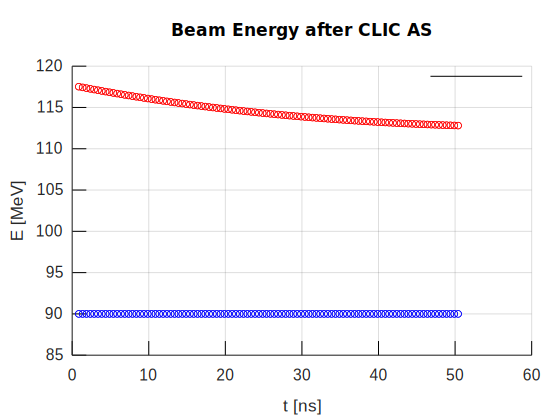

In [16]:
% Plots
figure
hold on
for bunch = 1:Nbunches
    M1 = mean(B1{bunch}.get_phase_space());
    M0 = mean(B{bunch}.get_phase_space());  
    scatter(M1(5) / RF_Track.ns, M1(6), 'r')
    scatter(M1(5) / RF_Track.ns, M0(6), 'b')
endfor

title('Beam Energy after CLIC AS', 'FontSize', 15)
grid on 
xlabel('t [ns]','FontSize',15)
ylabel('E [MeV]', 'FontSize', 15) 
h = legend('Final Energy','Initial Energy','Location','NorthEast');
set(h, 'FontSize',15)
set(gca, 'FontSize',12,'LineWidth',1)
